# Kalman Filter Multi-step Prediction

## Import and Initial Setup
Set directory to load log files from.

In [2]:
import os
import pandas as pd
import numpy as np
import rospkg

# Create a RosPack object
rospack = rospkg.RosPack()

# Get the path to the package this script is in
package_path = rospack.get_path('hri_predict_ros')

# Define the path to the logs directory
log_dir = os.path.join(package_path, 'logs')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Define the path to the plots directory
plot_dir = os.path.join(package_path, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Specify the path to the rosbag file
bag_file = os.path.join(log_dir, 'hri_predict_test.bag')

## Prediction Data Import
Import data from **.npz** files into Pandas dataframes.

In [3]:
df_pred_human_x = []
df_pred_human_var = []
array_filt_cov_mat = []

# Create an empty DataFrame
prediction_df = pd.DataFrame(columns=["timestamp", "pred_human_state", "pred_human_var"])

# Get all .npz files in the logs directory
npz_files = [file for file in os.listdir(log_dir) if file.endswith('.npz')]
num_files = len(npz_files) # Number of .npz files in the logs directory

# Load each .npz file and store the values in a pandas dataframe
for iter, file in enumerate(npz_files):
    print(f'Loading data for iteration {iter+1}/{num_files}')
    file_path = os.path.join(log_dir, file)
    data = np.load(file_path)
    timestamp = data['timestamp']
    pred_human_x = data['pred_human_x']
    pred_human_var = data['pred_human_var']
    filt_cov_mat = data['filt_cov_mat']

    prediction_df['timestamp'].append(timestamp)
    prediction_df['pred_human_state'].append(pred_human_x)
    prediction_df['pred_human_var'].append(pred_human_var)
    prediction_df['filt_cov_mat'].append(filt_cov_mat)

    # # Create and append dataframes
    # df_pred_human_x.append(pd.DataFrame(data=pred_human_x))
    # df_pred_human_var.append(pd.DataFrame(data=pred_human_var))

    # Append the covariance matrix to the list
    array_filt_cov_mat.append(filt_cov_mat)

Loading data for iteration 1/21
Loading data for iteration 2/21
Loading data for iteration 3/21
Loading data for iteration 4/21
Loading data for iteration 5/21
Loading data for iteration 6/21
Loading data for iteration 7/21
Loading data for iteration 8/21
Loading data for iteration 9/21
Loading data for iteration 10/21
Loading data for iteration 11/21
Loading data for iteration 12/21
Loading data for iteration 13/21
Loading data for iteration 14/21
Loading data for iteration 15/21
Loading data for iteration 16/21
Loading data for iteration 17/21
Loading data for iteration 18/21
Loading data for iteration 19/21
Loading data for iteration 20/21
Loading data for iteration 21/21


## Measurement Data Import
Import data from **.bag** files into Pandas dataframes.

**FIX: human_filt_pos not recorded in bag file. Repeat recording!!**

In [4]:
import rosbag

# Specify which topics to read from the rosbag file
topic_names = [
    '/ur10/joint_states',
    '/hri_prediction_node/human_filt_pos',
    '/hri_prediction_node/human_meas_pos'
]

robot_n_dof = 6
human_n_kpts = 18

# Create empty lists to store the data
timestamps = []
topics = []
messages = []

# Open the rosbag file
with rosbag.Bag(bag_file, 'r') as bag:
    # Iterate over each message in the bag
    for topic, msg, t in bag.read_messages(topics=topic_names): # type: ignore
        # Append the timestamp, topic, and message to the respective lists
        timestamps.append(t.to_sec())
        topics.append(topic)

        x = []

        if topic == '/ur10/joint_states':
            for i in range(robot_n_dof):
                x.append(msg.position[i])
                x.append(msg.velocity[i])
                x.append(msg.effort[i])

        elif topic == '/hri_prediction_node/human_meas_pos':
            for i in range(human_n_kpts):
                x.append(msg.poses[i].position.x)
                x.append(msg.poses[i].position.y)
                x.append(msg.poses[i].position.z)

        elif topic == '/hri_prediction_node/human_filt_pos':
            continue
        
        else:
            raise ValueError(f'Unknown topic: {topic}')
        
        messages.append(x)

# Create a dictionary to store the data
data = {'timestamp': timestamps, 'topic': topics, 'message': messages}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

## Manipulate Dataframe
- Pivoting
- Making timestamp relative
- Resampling

In [5]:
# Pivot the DataFrame
pivoted_df = df.pivot(index='timestamp', columns='topic', values='message') # use the timestamp as the index
pivoted_df = pivoted_df.reset_index() # reset the index to make the timestamp a column
print(f"Dataframe columns: {pivoted_df.columns.values}")

Dataframe columns: ['timestamp' '/hri_prediction_node/human_meas_pos' '/ur10/joint_states']


In [6]:
# Make the timestamp relative to the start of the recording
pivoted_df['timestamp'] = pivoted_df['timestamp'] - pivoted_df['timestamp'].iloc[0]

Unpack human measurement array into scalar values to assign to each column.

In [7]:
# Define the column names
column_names = []
for i in range(human_n_kpts):
    column_names.append(f'human_kpt{i+1}_x')
    column_names.append(f'human_kpt{i+1}_y')
    column_names.append(f'human_kpt{i+1}_z')

# Unpack the list into different columns and drop the original column
pivoted_df[column_names] = pivoted_df['/hri_prediction_node/human_meas_pos'].apply(pd.Series)
pivoted_df = pivoted_df.drop('/hri_prediction_node/human_meas_pos', axis=1)

Unpack robot joint state array into scalar values to assign to each column.

In [8]:
# Define the column names
column_names = []
for i in range(robot_n_dof):
    column_names.append(f'robot_j{i+1}_q')
    column_names.append(f'robot_j{i+1}_qd')
    column_names.append(f'robot_j{i+1}_qdd')

# Unpack the list into different columns and drop the original column
pivoted_df[column_names] = pivoted_df['/ur10/joint_states'].apply(pd.Series)
pivoted_df = pivoted_df.drop('/ur10/joint_states', axis=1)

Convert the timestamp to TimeDeltaIndex and resample according to specified dt.

In [9]:
# Convert the 'timestamp' column to a TimeDeltaIndex
pivoted_df['timestamp'] = pd.to_timedelta(pivoted_df['timestamp'], unit='s')

# Resample the DataFrame to a known frequency
dt = 0.01
freq_str = f'{dt}S' # seconds
resampled_df = pivoted_df.resample(freq_str, on='timestamp').mean() # compute the mean of the values in each time bin
resampled_df = resampled_df.reset_index() # reset the index to make the timestamp a column

## Plot timeseries
- Plot timeseries for measured and filtered states:
  - measured position
  - filtered position, velocity, acceleration

- Plot the predicted future states with their variance cone 

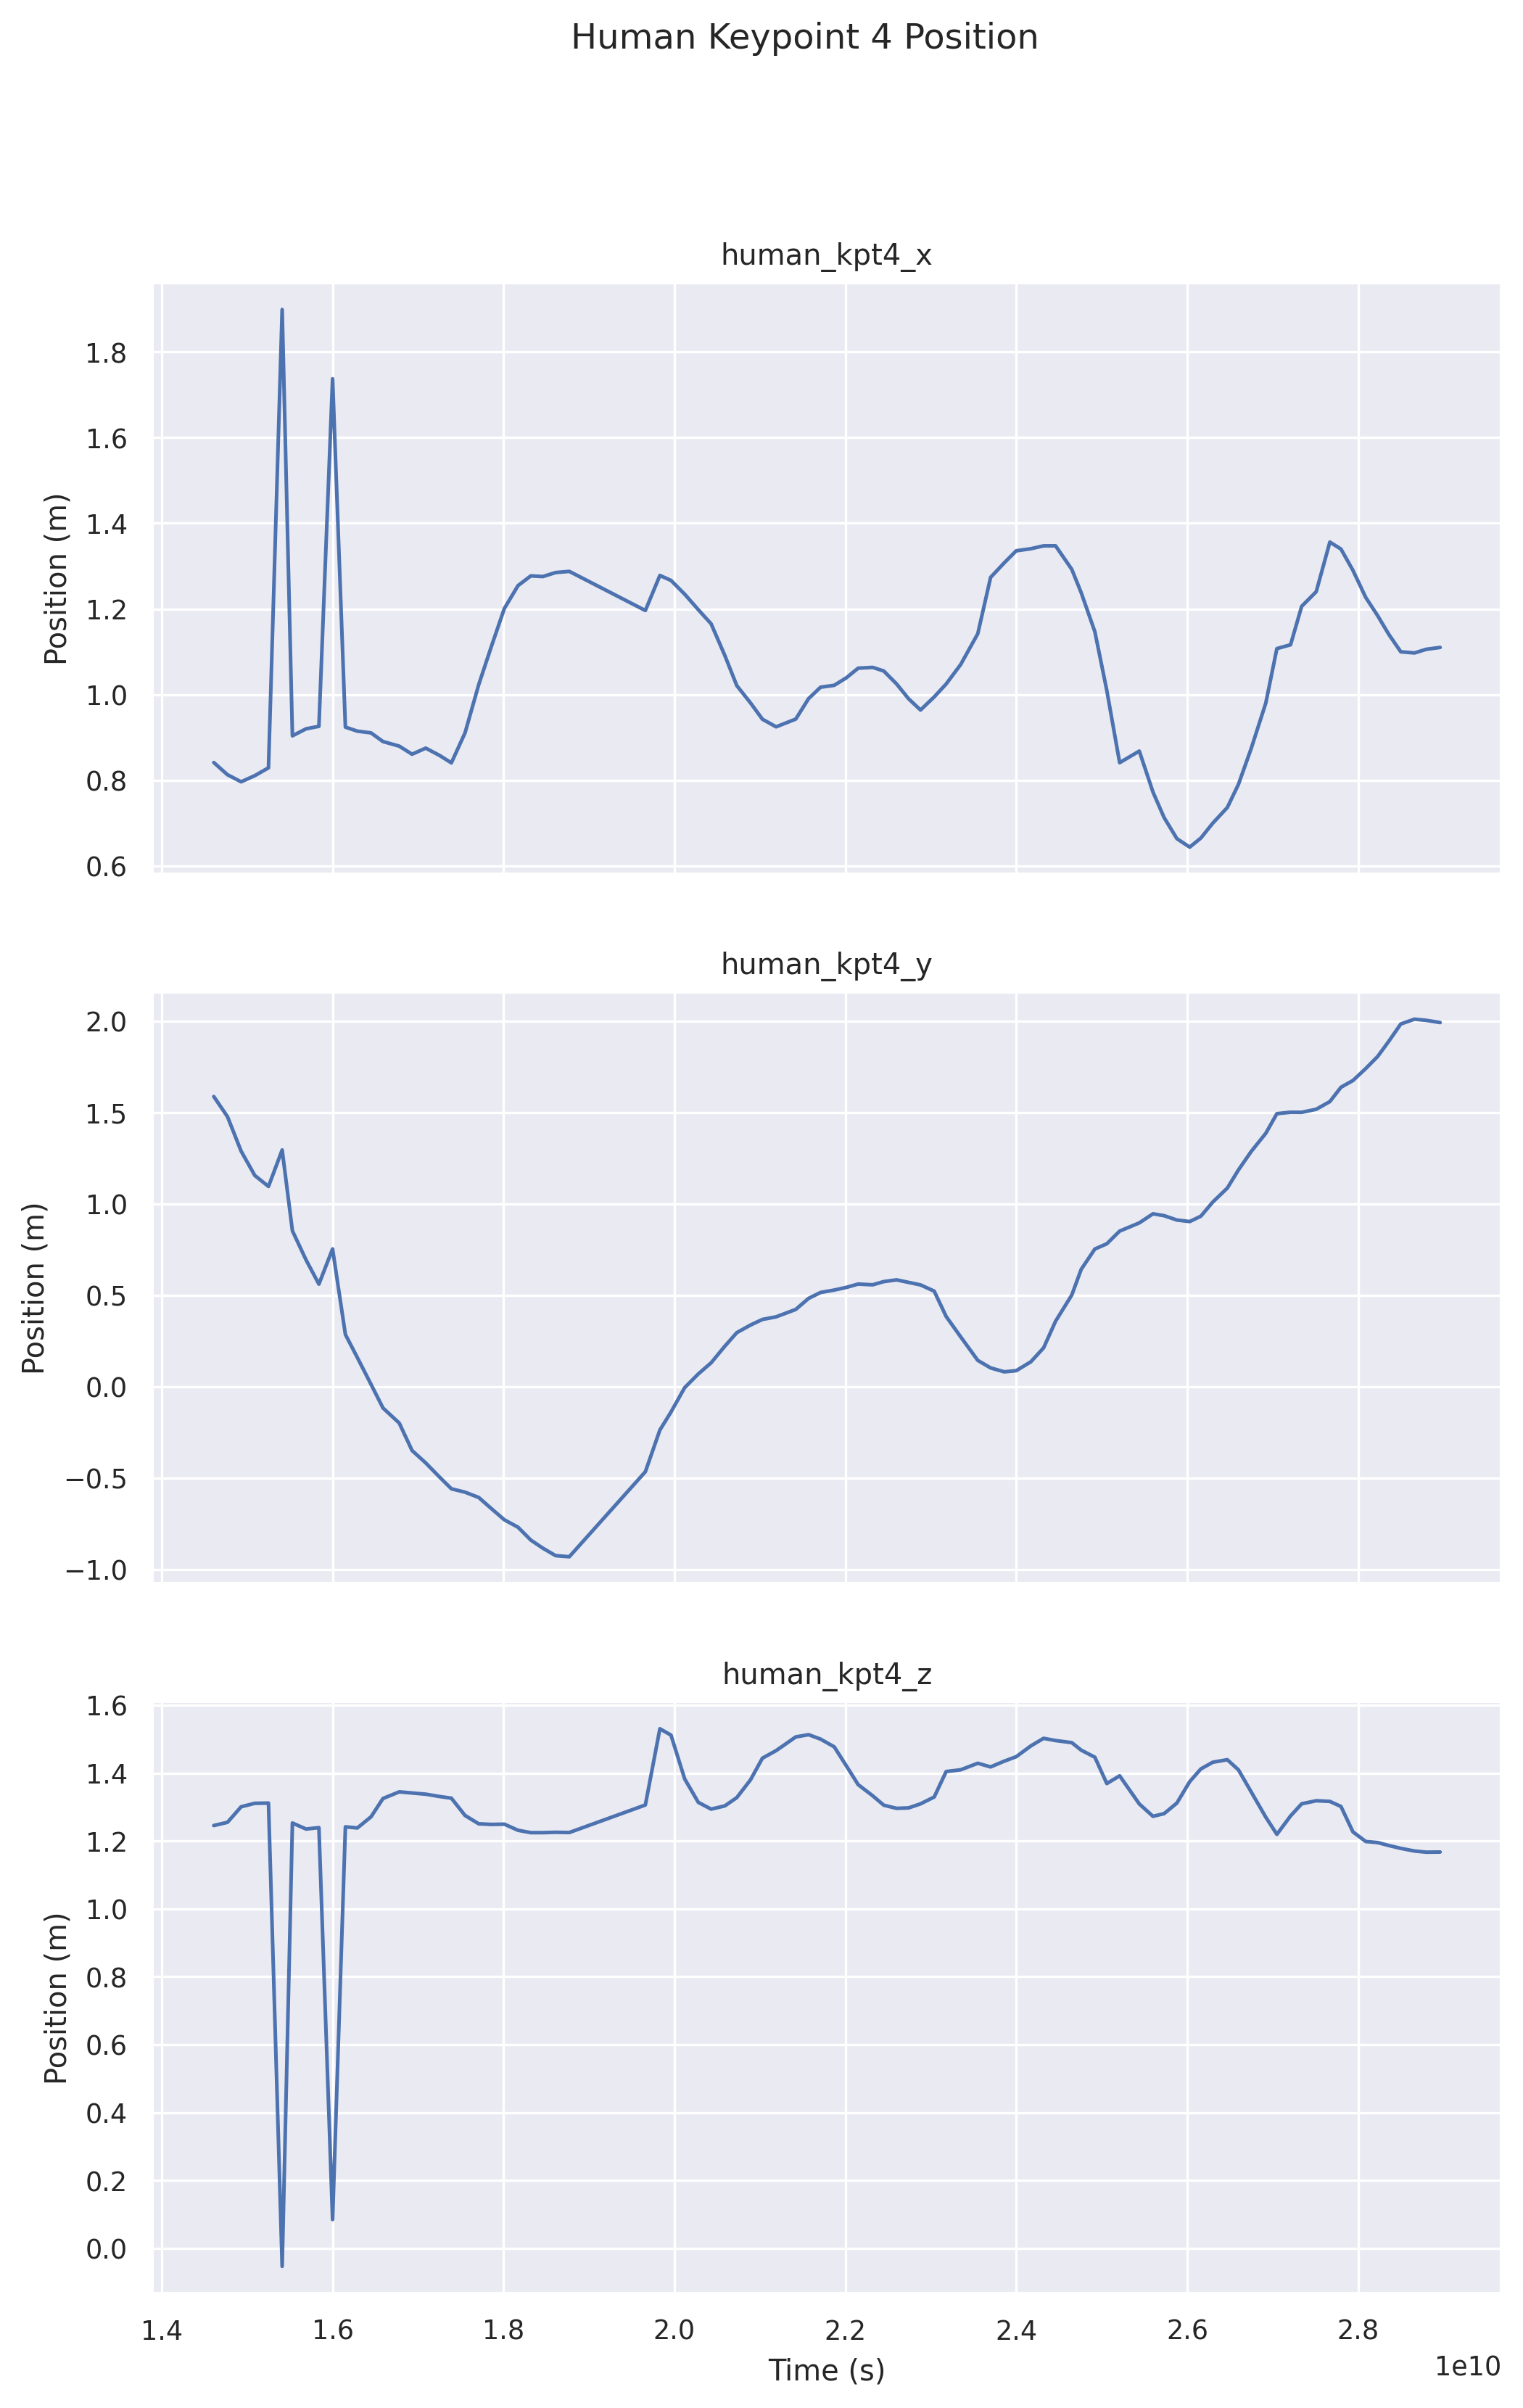

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')
sns.set_context("paper", font_scale=1.0)

columns_to_plot = ['human_kpt4_x', 'human_kpt4_y', 'human_kpt4_z']

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=len(columns_to_plot),
                         sharex=True,
                         dpi=300,
                         figsize=(8, 4*len(columns_to_plot))) # 6 inches high for each subplot
plt.xlabel('Time (s)')
plt.suptitle('Human Keypoint 4 Position')

# Plot each time series on a separate subplot
for i, column in enumerate(columns_to_plot):
    sns.lineplot(data=resampled_df, x=resampled_df['timestamp'], y=column, ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_ylabel('Position (m)')

Save the plot in vector format.

In [26]:
plt.savefig(os.path.join(plot_dir, 'human_kpt4_position.pdf'), format='pdf')
plt.show()

<Figure size 640x480 with 0 Axes>